In [1]:
import pickle
import sys
import numpy as np
import pandas as pd
import artm
import seaborn as sns
print artm.version()

from os import path, mkdir
from datetime import datetime
sys.path.insert(0, '..\\modules\\helpers')
from plot_helper import PlotMaker
from config_helper import ConfigPaths
from print_helper import PrintHelper
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
from scipy.optimize import minimize
from sklearn.metrics.pairwise import cosine_distances
from numpy.linalg import norm as euclidean_norm

%matplotlib inline

0.8.1


In [2]:
config = ConfigPaths('config_sample.cfg')
plot_maker = PlotMaker()
printer = PrintHelper()

In [3]:
print config.models_file_name
print config.dataset_path

Q:\\topic_modeling\\csi_science_collections.git\experiments\sample_model2\np_10_12_20_sampel_1\models.txt
Q:\\topic_modeling\\csi_science_collections.git\..\data\postnauka\UCI_collections\sample_model2


In [4]:
models_file = open(config.models_file_name, 'a')

In [20]:
def create_model(current_dictionary, n_topics, n_doc_passes, seed_value, n_top_tokens, p_mass_threshold):    
    print '[{}] creating model'.format(datetime.now())
    model = artm.ARTM(num_topics=n_topics, dictionary=current_dictionary, cache_theta=True, seed=seed_value, 
                  class_ids={'ngramm': 1.0, 'author_id': 0.0, 'author': 0.0, 
                             'post_tag': 0.0, 'projects': 0.0, 'category': 0.0,
                             'following_users': 0.0})
    model.num_document_passes = n_doc_passes
    add_scores_to_model(model, n_top_tokens=n_top_tokens, p_mass_threshold=p_mass_threshold)
    return model


def add_scores_to_model(artm_model, n_top_tokens, p_mass_threshold):
    print '[{}] adding scores'.format(datetime.now())
    artm_model.scores.add(artm.PerplexityScore(name='perplexity_score',
                                      use_unigram_document_model=False,
                                      dictionary=dictionary))
    artm_model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score', class_id='@default_class'))
    artm_model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
    artm_model.scores.add(artm.TopicKernelScore(name='topic_kernel_score', class_id='@default_class', 
                                                probability_mass_threshold=p_mass_threshold))
    artm_model.scores.add(artm.TopTokensScore(name='top_tokens_score', class_id='@default_class', num_tokens=n_top_tokens))
def fit_one_model(model, _n_iterations, _model_name=''): 
    print '[{}] fitting'.format(datetime.now())
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=_n_iterations)
    print '[{}] outputting'.format(datetime.now())
    printer.print_artm_model(model, _model_name, _n_iterations, output_file=models_file)
    model_pics_file_name =  path.join(config.experiment_path, _model_name)
    plot_maker.make_tm_plots(model, model_pics_file_name)
    model_output_file_name = path.join(config.experiment_path, _model_name + '.txt')
    printer.print_scores(model, _model_name, _n_iterations, model_output_file_name)
    printer.print_top_tokens(model, model_output_file_name)
    return model
def save_pickle_file(dists, filename):
    pickle_filename = path.join(config.experiment_path, filename)
    pickle_file = open(pickle_filename, 'wb')
    pickle.dump(dists, pickle_file)
    pickle_file.close()
def load_pickle_file(filename):
    pickle_filename = path.join(config.experiment_path, filename)
    pickle_file = open(pickle_filename, 'rb')
    p_file = pickle.load(pickle_file)
    pickle_file.close()
    return p_file

In [15]:
config.dataset_path = 'Q:\\topic_modeling\\csi_science_collections.git\..\data\postnauka\UCI_collections\sample_model2'
config.dataset_path  = path.join(config.dataset_path, 'pn.vw')
print config.dataset_path

Q:\topic_modeling\csi_science_collections.git\..\data\postnauka\UCI_collections\sample_model2\pn.vw


In [16]:
batch_vectorizer = artm.BatchVectorizer(data_path=config.dataset_path,
                                        data_format='vowpal_wabbit',
                                        collection_name=config.collection_name,
                                        target_folder=config.output_batches_path)
dictionary = artm.Dictionary()
dictionary.gather(data_path=config.output_batches_path)
dictionary.save(dictionary_path=config.dictionary_path)
dictionary.save_text(dictionary_path=config.dictionary_path + '.txt')
dictionary.load_text(dictionary_path=config.dictionary_path + '.txt')

In [ ]:
batch_vectorizer = artm.BatchVectorizer(data_path=config.output_batches_path,
                                        data_format='batches')
dictionary = artm.Dictionary()
dictionary.load(dictionary_path=config.dictionary_path + '.dict')

In [18]:
phi_convex_hull = load_pickle_file('phi_convex_hull_t2.p')
saved_top_tokens_convex_hull = load_pickle_file('saved_top_tokens_t2.p')

In [21]:
tmp_model = create_model(current_dictionary=dictionary, n_topics=20, n_doc_passes=5, seed_value=100,
                         n_top_tokens=15, p_mass_threshold=0.25)
tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
tmp_model.regularizers['ss_phi_regularizer'].tau = -2
tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 1e+6
tmp_model = fit_one_model(tmp_model, _n_iterations=15, _model_name='model1')
model1 = tmp_model; tmp_model = None

[2016-12-11 11:46:02.974000] creating model
[2016-12-11 11:46:04.600000] adding scores
[2016-12-11 11:46:04.618000] fitting
[2016-12-11 11:48:26.390000] outputting
name = model1, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 15, n_top_tokens = 15, p_threshold = 0.25
ss_theta_regularizer, tau = -1.5
decorrelator_phi_regularizer, tau = 1000000.0
ss_phi_regularizer, tau = -2



In [27]:
tmp_model = create_model(current_dictionary=dictionary, n_topics=20, n_doc_passes=5, seed_value=100,
                         n_top_tokens=15, p_mass_threshold=0.25)
tmp_model = fit_one_model(tmp_model, _n_iterations=15, _model_name='model2')
model2 = tmp_model; tmp_model = None

[2016-12-11 11:56:45.650000] creating model
[2016-12-11 11:56:46.879000] adding scores
[2016-12-11 11:56:46.879000] fitting
[2016-12-11 11:59:10.318000] outputting
name = model2, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 15, n_top_tokens = 15, p_threshold = 0.25



In [22]:
def euc_dist(p, q):
    return euclidean_norm(p - q)
def euc_dist_grad(b, A, x):
    x = x.reshape(-1, 1)
    b = b.reshape(-1, 1)
    norm = euc_dist(A.dot(x), b)
    res = A.T.dot(A.dot(x) - b)
    if norm != 0:
        res = res / norm
    return res
def cos_dist(p, q):
    p = p.reshape(-1, 1)
    q = q.reshape(-1, 1)
    return cosine_distances(p, q)[0][0]
def cos_dist_grad(b, A, x):
    x = x.reshape(-1, 1)
    b = b.reshape(-1, 1)
    y = A.dot(x)
    u = b.T.dot(y) # number
    deriv_u = A.T.dot(b) * x
    v = euclidean_norm(y) * euclidean_norm(b)
    nom = deriv_u * v - A.T.dot(A).dot(x) * u[0][0] * euclidean_norm(b) / euclidean_norm(y)
    denom = v * v
    if denom != 0:
        res = nom / denom
    else:
        res = nom
    return -res
def hellinger_dist(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / np.sqrt(2) 
def hellinger_dist_grad(b, A, x):
    y = A.dot(x)
    nom = np.divide(np.sqrt(y) - np.sqrt(b), np.sqrt(y)).dot(A)
    denom = 2 * hellinger_dist(y, b) * np.sqrt(2)
    res = nom / denom 
    return res
def hellinger_dist_grad_nan(b, A, x):
    y = A.dot(x)
    tmp = np.divide(np.sqrt(y) - np.sqrt(b), np.sqrt(y))
    tmp[np.isnan(tmp)] = 0
    nom = tmp.dot(A)
    denom = 2 * hellinger_dist(y, b) * np.sqrt(2)
    res = nom / denom 
    return res
def hellinger_dist_grad_eps(b, A, x):
    y = A.dot(x)
    y[y == 0] = 1e-3
    tmp = np.divide(np.sqrt(y) - np.sqrt(b), np.sqrt(y))
    nom = tmp.dot(A)
    denom = 2 * hellinger_dist(y, b) * np.sqrt(2)
    res = nom / denom 
    return res

In [34]:
def print_optimal_solution_eps(_sol):
    _eps = 1e-2
    x = _sol.x
    c = _sol.column_names
    x_mask = x >_eps
    x_cut = x[x_mask]
    c_cut = c[x_mask]
    combination = ', '.join(['{} : {}'.format(c_cut[ind], x_cut[ind]) for ind in range(len(x_cut))])
    print 'fun = {}, optimized = {}'.format(_sol.fun, _sol.success)
    print '{}: {}'.format(_sol.optimized_column, combination)
def print_optimal_solution(_sol, _distances=None, _saved_top_tokens=None):
    x = _sol.x
    c = _sol.column_names
    sorted_x = sorted(zip(x, c), reverse=True)[0 : NUM_INDICES]
    if _distances is not None:
        combination = ', '.join(['{0} : {1:0.2f} [{2:0.2f}]'.format(item[1], item[0], _distances[_sol.optimized_column][item[1]]) for item in sorted_x])
        combination += '\n' + distances_to_str_row(_distances, _sol.optimized_column, _n_topics=NUM_INDICES)
    else:
        combination = ', '.join(['{0} : {1:0.2f}'.format(item[1], item[0]) for item in sorted_x])
    print '============================'
    print 'fun = {}, optimized = {}'.format(_sol.fun, _sol.success)
    print '{} | {}'.format(_sol.optimized_column, combination)
    if _saved_top_tokens is not None:
        topics_str = optimal_solution_topics_to_str(_saved_top_tokens, _sol.optimized_column, sorted_x)
        print topics_str
    print '============================'
def unicode_list_to_str(_name, _list):
    return _name + ': ' + ' '.join(_list)
def optimal_solution_topics_to_str(_saved_top_tokens, topic_name, sorted_x):
    topics = [item[1] for item in sorted_x]
    topics.insert(0, topic_name)
    str = ""
    for topic_name in topics:
        str += unicode_list_to_str(topic_name, _saved_top_tokens[topic_name]) + '\n'
    return str
def calculate_distances(dist_fun, _phi, _phi_other):
    print '[{}] take_distances between {} columns and {} columns'.format(datetime.now(), len(_phi.columns), len(_phi_other.columns))
    distances = pd.DataFrame(0, index = _phi.columns, columns=_phi_other.columns)
    for idx, col in enumerate(_phi.columns):
        print '[{}] column num {} of {}'.format(datetime.now(), idx, len(_phi.columns))
        for idx_other, col_other in enumerate(_phi_other.columns):
            distance = dist_fun(_phi[col], _phi_other[col_other])
            distances.iloc[idx, idx_other] = distance
    return distances
def distances_to_str_row(distances, topic, _n_topics):
    values = distances[topic].sort_values().head(_n_topics)
    value = ', '.join(['{0} : [{1:0.2f}]'.format(values.index[ind], values[ind]) for ind in range(len(values))])
    str = 'closest by distance to {} | {}\n'.format(topic, value)
    return str
def calculate_distances_one_col(dist, phi, column): 
    distances = pd.DataFrame(0, index = range(1), columns=phi.columns)
    for idx, col in enumerate(phi.columns):
        distance = dist(column, phi[col])
        distances.iloc[0, idx] = distance
    return distances
def get_optimization_result(dist_fn, jac_dist_fn, phi, phi_other, distances):
    opt_results = {}
    for col_idx, col in enumerate(phi.columns):
        print '[{}] get_optimization_result for column {}'.format(datetime.now(), col_idx)
        opt_results[col] = solve_optimization_problem(dist_fn, jac_dist_fn, col_idx, phi, phi_other, distances)
    return opt_results
def solve_optimization_problem(dist_fn, jac_dist_fn, col_idx, phi, phi_other, distances, verbose=False):
    max_iter = 50
    col_name = phi.columns[col_idx]
    col = phi[col_name]
    # get n closest topics
    closest_indices = distances[col_name].sort_values().head(N_CLOSEST_TOPICS).index.values
    phi_other_closest = phi_other[closest_indices]
    
    # opt solver
    n_columns = phi_other_closest.shape[1] 
    bnds = [(0, 1)] * n_columns
    constraints = cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1, 'jac': lambda x: [1] * n_columns})
    opt_fun = lambda x: dist_fn(col, phi_other_closest.dot(x))
    jac_fun = lambda x: jac_dist_fn(col, phi_other_closest, x)
    
    is_optimized = False
    it = 0
    while (not is_optimized) and it != 4:
        it += 1
        init_x = np.random.uniform(0, 1, (1, n_columns))
        init_x /= np.sum(init_x)
        if jac_dist_fn is not None:
            res = minimize(opt_fun, jac=jac_fun, x0=init_x, method='SLSQP', bounds=bnds, constraints=cons, options={'maxiter': max_iter, 'disp': verbose})
        else:
            res = minimize(opt_fun, x0=init_x, method='SLSQP', bounds=bnds, constraints=cons, options={'maxiter': max_iter, 'disp': verbose})
        is_optimized = res.success
    res['column_names'] = phi_other_closest.columns
    res['optimized_column'] = col_name
    return res

In [24]:
N_CLOSEST_TOPICS = 50
NUM_INDICES = 10
phi1 = model1.get_phi()
saved_top_tokens1 = model1.score_tracker['top_tokens_score'].last_tokens

phi = phi1
saved_top_tokens = saved_top_tokens1

In [25]:
distances = calculate_distances(hellinger_dist, phi_convex_hull, phi)

[2016-12-11 11:48:53.499000] take_distances between 20 columns and 449 columns
[2016-12-11 11:48:53.500000] column num 0 of 20
[2016-12-11 11:49:19.370000] column num 1 of 20
[2016-12-11 11:49:42.376000] column num 2 of 20
[2016-12-11 11:50:05.852000] column num 3 of 20
[2016-12-11 11:50:31.045000] column num 4 of 20
[2016-12-11 11:50:53.212000] column num 5 of 20
[2016-12-11 11:51:15.198000] column num 6 of 20
[2016-12-11 11:51:36.993000] column num 7 of 20
[2016-12-11 11:51:58.917000] column num 8 of 20
[2016-12-11 11:52:20.317000] column num 9 of 20
[2016-12-11 11:52:41.439000] column num 10 of 20
[2016-12-11 11:53:03.567000] column num 11 of 20
[2016-12-11 11:53:25.702000] column num 12 of 20
[2016-12-11 11:53:48.485000] column num 13 of 20
[2016-12-11 11:54:10.824000] column num 14 of 20
[2016-12-11 11:54:32.478000] column num 15 of 20
[2016-12-11 11:54:55.768000] column num 16 of 20
[2016-12-11 11:55:24.104000] column num 17 of 20
[2016-12-11 11:55:50.462000] column num 18 of 20


In [35]:
ds1 = get_optimization_result(hellinger_dist, None, phi, phi_convex_hull, distances)
ds = ds1
save_pickle_file(ds, 'dists_h_none.p')

[2016-12-11 12:01:13.413000] get_optimization_result for column 0
[2016-12-11 12:01:18.663000] get_optimization_result for column 1
[2016-12-11 12:01:22.510000] get_optimization_result for column 2
[2016-12-11 12:01:27.637000] get_optimization_result for column 3
[2016-12-11 12:01:32.119000] get_optimization_result for column 4
[2016-12-11 12:01:36.122000] get_optimization_result for column 5
[2016-12-11 12:01:39.632000] get_optimization_result for column 6
[2016-12-11 12:01:44.399000] get_optimization_result for column 7
[2016-12-11 12:01:48.254000] get_optimization_result for column 8
[2016-12-11 12:01:51.667000] get_optimization_result for column 9
[2016-12-11 12:01:56.845000] get_optimization_result for column 10
[2016-12-11 12:02:00.300000] get_optimization_result for column 11
[2016-12-11 12:02:03.834000] get_optimization_result for column 12
[2016-12-11 12:02:09.128000] get_optimization_result for column 13
[2016-12-11 12:02:12.621000] get_optimization_result for column 14
[2016

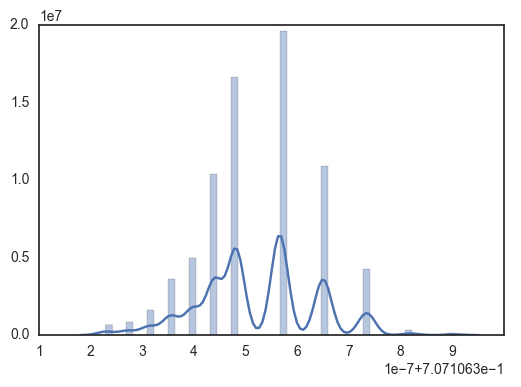

In [36]:
# построим распределение полученных distances, построим распределение полученных opt_fun 
%matplotlib inline
sns.distplot(distances.values.flatten())

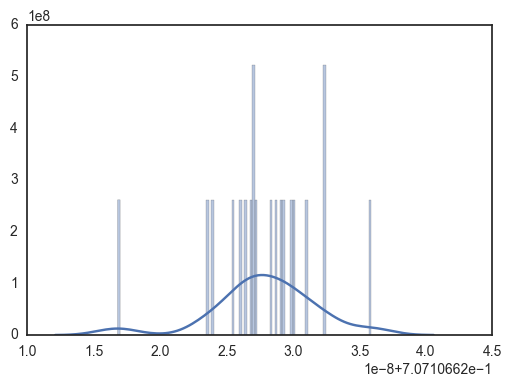

In [37]:
fs = [ds[col].fun for col in phi.columns]
sns.distplot(fs, bins=100)

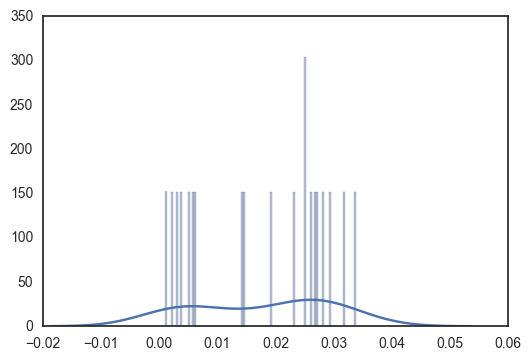

In [38]:
xs = [ds[col].x[0] for col in phi.columns]
sns.distplot(xs, bins=100)

In [40]:
opt_res_convex_hull, distances_convex_hull = ds, distances

In [45]:
for topic_name in phi.columns:
    print_optimal_solution(opt_res_convex_hull[topic_name], _distances=distances_convex_hull)

fun = 0.707106652408, optimized = True
topic_0 | topic_324 : 0.05 [0.71], topic_46 : 0.04 [0.71], topic_19 : 0.04 [0.71], topic_125 : 0.04 [0.71], topic_131 : 0.04 [0.71], topic_362 : 0.04 [0.71], topic_245 : 0.04 [0.71], topic_273 : 0.04 [0.71], topic_477 : 0.04 [0.71], topic_85 : 0.03 [0.71]
closest by distance to topic_0 | topic_497 : [0.71], topic_20 : [0.71], topic_428 : [0.71], topic_37 : [0.71], topic_328 : [0.71], topic_294 : [0.71], topic_298 : [0.71], topic_344 : [0.71], topic_140 : [0.71], topic_122 : [0.71]

fun = 0.707106648673, optimized = True
topic_1 | topic_120 : 0.04 [0.71], topic_131 : 0.04 [0.71], topic_317 : 0.04 [0.71], topic_20 : 0.03 [0.71], topic_122 : 0.03 [0.71], topic_470 : 0.03 [0.71], topic_19 : 0.03 [0.71], topic_362 : 0.03 [0.71], topic_373 : 0.03 [0.71], topic_328 : 0.03 [0.71]
closest by distance to topic_1 | topic_497 : [0.71], topic_20 : [0.71], topic_428 : [0.71], topic_37 : [0.71], topic_328 : [0.71], topic_294 : [0.71], topic_298 : [0.71], topic_3

In [ ]:
# model2

In [46]:
phi2 = model2.get_phi()
saved_top_tokens2 = model2.score_tracker['top_tokens_score'].last_tokens

phi = phi2
saved_top_tokens = saved_top_tokens2

In [48]:
distances = calculate_distances(hellinger_dist, phi, phi_convex_hull).T

[2016-12-11 12:08:44.818000] take_distances between 20 columns and 449 columns
[2016-12-11 12:08:44.819000] column num 0 of 20
[2016-12-11 12:09:08.561000] column num 1 of 20
[2016-12-11 12:09:29.388000] column num 2 of 20
[2016-12-11 12:09:54.950000] column num 3 of 20
[2016-12-11 12:10:18.245000] column num 4 of 20
[2016-12-11 12:10:42.751000] column num 5 of 20
[2016-12-11 12:11:05.876000] column num 6 of 20
[2016-12-11 12:11:30.498000] column num 7 of 20
[2016-12-11 12:11:53.538000] column num 8 of 20
[2016-12-11 12:12:16.806000] column num 9 of 20
[2016-12-11 12:12:37.922000] column num 10 of 20
[2016-12-11 12:13:01.934000] column num 11 of 20
[2016-12-11 12:13:26.878000] column num 12 of 20
[2016-12-11 12:13:53.230000] column num 13 of 20
[2016-12-11 12:14:19.420000] column num 14 of 20
[2016-12-11 12:14:46.921000] column num 15 of 20
[2016-12-11 12:15:13.846000] column num 16 of 20
[2016-12-11 12:15:44.357000] column num 17 of 20
[2016-12-11 12:16:18.248000] column num 18 of 20


In [ ]:
def get_topics_to_remove_by_closest_dist(small_dist_opts, distances):
    n_closest = 10
    sorted_by_fun = sorted(small_dist_opts.values(), key = lambda opt: opt.x[0])
    topics_to_remove = []
    for opt_res in sorted_by_fun:
        topic_name = opt_res.optimized_column
        # check not close to current topics to remove
        is_closest = lambda topic, other_topic: np.any(distances[topic].sort_values().head(n_closest).index.values == other_topic)
        dists_to_topics_to_remove = [not is_closest(topic_name, t) for t in topics_to_remove]
        is_far = np.all(np.array(dists_to_topics_to_remove))
        if is_far:
            topics_to_remove.append(topic_name)
    return topics_to_remove
def find_topics_to_remove(_opt_res, _phi_convex_hull, _distances_convex_hull, x_th):     
    possible_duplicates_opts = {col: _opt_res[col] for col in _phi_convex_hull.columns if _opt_res[col].x[0] > x_th}
    print len(possible_duplicates_opts)
    topics_to_remove_by_closest_dist = get_topics_to_remove_by_closest_dist(possible_duplicates_opts, _distances_convex_hull)
    print 'topics to remove = ', len(topics_to_remove_by_closest_dist)
    print '\n'.join([unicode_list_to_str(topic_name, saved_top_tokens[topic_name][0:11]) for topic_name in topics_to_remove_by_closest_dist])
    return topics_to_remove_by_closest_dist
def remove_topics_from_phi(phi, topics_to_remove):
    return phi.drop(topics_to_remove, axis=1)
def remove_topics_from_distances(distances, topics_to_remove):
    distances_convex_hull = distances.drop(topics_to_remove, axis=1)
    distances_convex_hull = distances_convex_hull.drop(topics_to_remove, axis=0)
    return distances_convex_hull

In [ ]:
phi_convex_hull, distances_convex_hull, opt_res_convex_hull = phi, distances, ds

In [ ]:
# iteration = 1

In [ ]:
x_th = 0.4
topics_to_remove_by_closest_dist = find_topics_to_remove(opt_res_convex_hull, phi_convex_hull, distances_convex_hull, x_th)

In [ ]:
phi_convex_hull = remove_topics_from_phi(phi_convex_hull, topics_to_remove_by_closest_dist)
distances_convex_hull = remove_topics_from_distances(distances_convex_hull, topics_to_remove_by_closest_dist)

In [ ]:
vals = distances_convex_hull.values.flatten()
sns.distplot(vals[vals != 0])

In [ ]:
models_file.close()